# ASHRAE ENERGY PREDICTION III

**Made By:**
**Reem Tarek, Asmaa Elsayed, Hanya Mostafa**

# 1.Business Problem :


## 1.1 Description :


ASHERE (American Society of Heating and Air-Conditioning Engineers) is a company that focuses on the energy efficiency and building systems in the industry. They launched a compition on Kaggle to find the best prediction model for energy consumption i the upcoming years for their invetmentsin energy efficiency.

They provided some data in the comption like the hourly consumption of 4 different energy types consumed in 16 different sites for a year duration. The compition requires from the contestants to predict the hourly consumption of these 4 energiesin the upcoming next 2 years.

## 1.2 Problem Statement :

The problem at hand is to take the energy consumption reading for the 4 different energies ( meter 0 :Electricity , 1 : Chilled Water , 2 : steam, 3: Hotwater ) with the given information of building,weather data and meter-reading of a past year. The company uses these kind of prediction to give its invertors as idea on the right kind of investments to reduce the cost.

## 1.3 Sources/Useful Links


**Useful resourses:**

1.   https://www.kaggle.com/corochann/ashrae-feather-format-for-fast-loading
2.   https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
3.   https://medium.com/analytics-vidhya/ashrae-great-energy-predictor-iii-a-machine-learning-case-study-a01a67eb048d
4.   https://medium.com/@chandanaroyal99/ashrae-great-energy-predictor-iii-case-study-66a25acd77f0




# 2. Machine Learning Probelm


## 2.1 Data


**train.csv:** 
  1. building_id - Foreign key for the building metadata.
  2. meter - The meter id code. Read as {0: electricity, 1: chilledwater, 2: steam, 3: hotwater}. Not every building has all meter types.
  2. timestamp - When the measurement was taken
meter_reading - The target variable. Energy consumption in kWh (or equivalent). Note that this is real data with measurement error, which we expect will impose a baseline level of modeling error.
  3. site_id - Foreign key for the weather files.
  4. building_id - Foreign key for training.csv
  5. primary_use - Indicator of the primary category of activities for the building based on EnergyStar property type definitions
  6. square_feet - Gross floor area of the building
  7. year_built - Year building was opened
  8. floor_count - Number of floors of the building


**weather_[train/test].csv**: Weather data from a meteorological station as close as possible to the site.

  1. site_id
  2. air_temperature - Degrees Celsius
  3. cloud_coverage - Portion of the sky covered in clouds, in oktas
  4. dew_temperature - Degrees Celsius
  5. precip_depth_1_hr - Millimeters
  6. sea_level_pressure - Millibar/hectopascals
  7. wind_direction - Compass direction (0-360)
  8. wind_speed - Meters per second

**test.csv**: The submission files use row numbers for ID codes in order to save space on the file uploads. test.csv has no feature data; it exists so you can get your predictions into the correct order.

  1. row_id - Row id for your submission file
  2. building_id - Building id code
  3. meter - The meter id code
  4. timestamp - Timestamps for the test data period
  
**sample_submission.csv**: A valid sample submission. 
  1. All floats in the solution file were truncated to four decimal places; we recommend you do the same to save space on your file upload.

  2. There are gaps in some of the meter readings for both the train and test sets. Gaps in the test set are not revealed or scored.

# 2.2 Type of Machine Leaning Problem

It is a Regression problem, given meter type used and weather of a building predict the meter reading.

# 2.3 Performance Metric

he evaluation metric for this competition is Root Mean Squared Logarithmic Error.

The RMSLE is calculated as

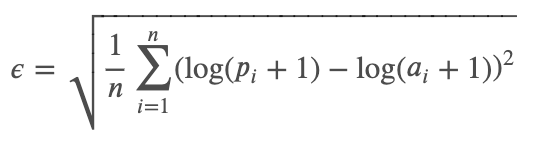

# 3.Loading Data

## 3.1 Importing necessary libraries

In [ ]:
# Importing needed libraries to be used throughout the project

%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import warnings
warnings.filterwarnings('ignore')

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

## 3.2 Loading the ASHRAE dataset

In [ ]:
data_path = "/kaggle/input/ashrae-energy-prediction/"

train_path = data_path + "train.csv"
test_path = data_path + "test.csv"

building_path = data_path + "building_metadata.csv"

weather_train_path = data_path + "weather_train.csv"
weather_test_path = data_path + "weather_test.csv"

In [ ]:
train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)

building_data = pd.read_csv(building_path)

weather_train_data = pd.read_csv(weather_train_path)
weather_test_data = pd.read_csv(weather_test_path)

## 3.3 Viewing Snippets of the dataset

In [ ]:
train_data.head()

In [ ]:
train_data.describe()

In [ ]:
train_data.info()

In [ ]:
test_data.head()

In [ ]:
building_data.head()

In [ ]:
weather_train_data.head()

In [ ]:
weather_test_data.head()

In [ ]:
print('Shape of Train Data:',train_data.shape)
print('Shape of Test Data:', test_data.shape)
print('Shape of Building Data:', building_data.shape)
print('Shape of Weather Train Data:', weather_train_data.shape)
print('Shape of Weather Test Data:', weather_test_data.shape)

## 3.4 Converting data to feather format for faster loading

In [ ]:
# Converting data into feather format since some dataframes are too large and take a long time to load
# This method is inspired from the kaggle notebook titled: ASHRAE: feather format for fast loading
# Which is found at: https://www.kaggle.com/corochann/ashrae-feather-format-for-fast-loading

train_data.to_feather('train_data.feather')
test_data.to_feather('test_data.feather')

building_data.to_feather('building_data.feather')

weather_train_data.to_feather('weather_train_data.feather')
weather_test_data.to_feather('weather_test_data.feather')


In [ ]:
train_data = pd.read_feather('train_data.feather')
test_data = pd.read_feather('test_data.feather')

building_data = pd.read_feather('building_data.feather')

weather_train_data = pd.read_feather('weather_train_data.feather')
weather_test_data = pd.read_feather('weather_test_data.feather')


## 3.5 Reducing the memory usage of the data

In [ ]:
# This function helps in optimizing the memory used by the dataframes by by modifying/altering thedatatype of each column.
# This method is inspired from the kaggle notebook titled: load data (reduce memory usage)
# Which is found at: https://www.kaggle.com/gemartin/load-data-reduce-memory-usage

def reduce_mem_usage(df, df_name):

    start_mem = df.memory_usage().sum() / 1024**2
    
    for col in df.columns:

        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2

    print('Memory usage of {} is reduced by {:.2f} %. Usage dropped from {:.2f} MB to {:.2f} MB.'.format(df_name, (100 * (start_mem - end_mem) / start_mem), start_mem, end_mem))
    
    return df


In [ ]:
train_data = reduce_mem_usage(train_data, 'Train Data')
test_data = reduce_mem_usage(test_data, 'Test Data')

building_data = reduce_mem_usage(building_data, 'Building Data')

weather_train_data = reduce_mem_usage(weather_train_data, 'Weather Train Data')
weather_test_data = reduce_mem_usage(weather_test_data, 'Weather Test Data')

## 3.6 Merging Data

In [ ]:
train = train_data.merge(building_data, on='building_id', how='left')
train = train.merge(weather_train_data, on=['site_id', 'timestamp'], how='left')

In [ ]:
test = test_data.merge(building_data, on='building_id', how='left')
test = test.merge(weather_test_data, on=['site_id', 'timestamp'], how='left')

In [ ]:
train.head()

In [ ]:
test.head()

In [ ]:
print('Shape of Combined Train Data:',train.shape)
print('Shape of Combined Test Data:', test.shape)

## 3.7 Breaking Timestamp into Hour, Day, Month, Year

In [ ]:
# This function firstly converts timestamp to date and then breaks down date into 6 new columns: hour, day, dayOfWeek, dayOfYear, month and year

def breakdown_timestamp(dataframe):
    
    dataframe['timestamp']= pd.to_datetime(dataframe['timestamp'])

    dataframe['hour']= np.uint8(dataframe['timestamp'].dt.hour)
    
    dataframe['day']= np.uint16(dataframe['timestamp'].dt.day)
    dataframe['dayofweek']= np.uint8(dataframe['timestamp'].dt.dayofweek)
    dataframe['dayofyear']= np.uint16(dataframe['timestamp'].dt.dayofyear)

    dataframe['month']= np.uint8(dataframe['timestamp'].dt.month)

    dataframe['year']= np.uint16(dataframe['timestamp'].dt.year)
    
    return dataframe

In [ ]:
train = breakdown_timestamp(train)
test = breakdown_timestamp(test)

In [ ]:
print('New Shape of Train Data:',train.shape)
print('New Shape of Test Data:', test.shape)

# 4. EDA

## 4.1 Exploring the Target Value 'Meter Reading'

In [ ]:
# This Function Draws the distribution plot for the column passed into the function's arguments

sns.set_theme()

def draw_distribution_graph(dataframe, column_name):
    
    fig, ax = plt.subplots(figsize=(8, 8))
    sns.distplot(dataframe[column_name], color='purple', ax = ax).set_title("Distribution Graph for {}".format(column_name), fontsize=16)
    plt.xlabel(column_name, fontsize=12)
    plt.ylabel('Density', fontsize=12)
    plt.show()

In [ ]:
draw_distribution_graph(train, 'meter_reading')

In [ ]:
print('Meter Reading has a skewness of', train['meter_reading'].skew())

**Observations:**
1. The Meter Reading is extremely skewed to the left.
2. We need to apply log tranformation to fix the skewness.


In [ ]:
train['meter_reading']=np.log1p(train['meter_reading'])

In [ ]:
draw_distribution_graph(train, 'meter_reading')

In [ ]:
print('Meter Reading has a new skewness of', train['meter_reading'].skew())

**Observations:**
- The most recurrent meter reading is zero. (This will be taken care of in the data preperation section)


## 4.2 Exploring Different Meter Types

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
meter_types_labels = ['Electricity', 'Chilled Water', 'Steam', 'Hot Water']
sns.countplot(x = 'meter', data = train).set_title("Frequency of Readings by the Different Meter Types", fontsize=16)
ax.set_xticklabels(meter_types_labels)
plt.xlabel('Meter Type', fontsize=12)
plt.ylabel('Readings Count', fontsize=12)
plt.show()

**Observations:**
1. Electricity meters are the most meters used in buildings. 
2. Hot Water meters are the least used in buildings.


In [ ]:
# Making a copy of the dataset to group by meter type

fig, ax = plt.subplots(figsize=(8,8))
meter_types = train.groupby('meter').meter_reading.mean().reset_index()
sns.barplot(x ='meter', y ='meter_reading', data = meter_types).set_title("Average Log Reading for Each Meter Type", fontsize=16)
ax.set_xticklabels(meter_types_labels)
plt.xlabel('Meter Type', fontsize=12)
plt.ylabel('Average Log Reading', fontsize=12)
plt.show()

**Observations:**
1. Steam meters consume the most energy and thus are the least energy efficient out of the 4 meter types.
2. Hot Water meters consume the least energy.


## 4.3 Exploring Frequency of the Different Primary Use Categories 

In [ ]:
plt.figure(figsize=(8,8))
sns.countplot(x = 'primary_use', data = train).set_title("Frequency of Primary Use Categories", fontsize=16)
plt.xticks(rotation=90)
plt.xlabel('Primary Use Category', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

**Observations:**
1. Educational buildings contribute the largest number of readings. 
2. Religious worships contribute the least readings.

## 4.4 Exploring Average Meter Reading Per Site and Use Category

In [ ]:
site_use_grouping = train.groupby(['site_id','primary_use'])['meter_reading'].mean().unstack('primary_use')
site_use_grouping.plot(kind = 'bar', stacked = True, figsize=(18,10)).set_title("Average Log Meter Reading per site and use category")
plt.xlabel('Site Id')
plt.ylabel('Log Meter Reading')
plt.legend(loc = "upper left")
plt.show()

**Observations:**
1. Site 13 has the highest average meter readings.
2. Site 11 has the least average meter readings and buildings in this site are primarily used as educational institutions.

## 4.5 Exploring Average Readings per Hour and Month

In [ ]:
hour_groups = train.groupby(['timestamp','hour']).meter_reading.mean().reset_index()
month_groups = train.groupby(['timestamp','month']).meter_reading.mean().reset_index()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20,8))
fig.suptitle('Average Readings According to Hour and Month')

sns.lineplot(x = hour_groups['hour'], y = hour_groups['meter_reading'], color='green', ax = ax1)
ax1.set_title('Average Reading According to Hour')


sns.lineplot(x = month_groups['month'], y = month_groups['meter_reading'], color='purple', ax = ax2)
ax2.set_title('Average Reading According to Month')

plt.show()

**Observations:**
1. Energy consumption drops in the early hours of the morning around 3-4am and rises again after 5am.
2. The hourly usage is maximized in the duration of 12-3pm, peeking at 1 in the afternoon Which is a logical conclusion as many instituitions work around this period.
3. Energy Consumption is minimal during the period of January to March, reaching its lowest in March.
4. Consumption starts rising gradually from April and reaches a peek in August.


##  4.6 Exploring Average Readings per Building

In [ ]:
building_groups = train.groupby(['building_id']).meter_reading.mean().reset_index()

plt.figure(figsize=(8,8))
sns.lineplot(x = building_groups['building_id'], y = building_groups.meter_reading).set_title("Average Log Meter Reading According to Building Id", fontsize=16)
plt.xlabel('Building Id', fontsize=12)
plt.ylabel('Average Log Meter Reading', fontsize=12)
plt.xticks(rotation=45)
plt.show()

##  4.7 Checking Missing Values

In [ ]:
missing_values = pd.DataFrame(train.isnull().sum() * 100 / len(train))
missing_values.columns = ["Missing Values"]

missing_values = missing_values[missing_values["Missing Values"] != 0]
missing_values.sort_values(by = "Missing Values", axis = 0, ascending = False, inplace = True)

missing_values

In [ ]:
plt.figure(figsize=(8,8))
sns.barplot(x = missing_values['Missing Values'], y = missing_values.index).set_title("Missing Value Percentage Per Feature", fontsize=16)
plt.xlabel('Percentage Missing', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.show()

**Observations:**
1. Floor count has the highest number of missing values, with a percentage reaching 82.6 %.
2. Year Built is the second leading column in missing values with almost 60% of the data being null.
3. This needs to be taken care of during the data preparation process before feeding it to the models for training.

## 4.8 Visualizing Correlation Between the Different Features 

In [ ]:
correlation_matrix = train.corr()

In [ ]:
plt.figure(figsize=(18,18))
sns.heatmap(correlation_matrix, annot = True, vmin = -1, vmax = 1, cmap = "YlGnBu").set_title('Correlation Matrix')
plt.show()

In [ ]:
target_corr_df = pd.DataFrame(correlation_matrix["meter_reading"].sort_values(ascending=False))
target_corr_df 

**Observations:**
1. Site Id is extremely correlated with the Building Id (Correlation of 1).
2. Drew Tempreture and Air Tempreture have the second highest correlation, with a correlation of 0.8.
3. No features have a strong correlation with the target value 'Meter Reading'.

## 4.9  Visualizing Features Histograms

In [ ]:
train.hist(bins=50, figsize=(24,15))
plt.suptitle('Histograms For the Different Features', fontsize=16)
plt.show()

**Observations:**
- Square Feet is heavily skewed to the left, therefore, we need to apply log transformation to fix that.

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20,8))
fig.suptitle('Square Feet Before and After Fixing Skewness')

sns.distplot(train['square_feet'], color='purple', ax = ax1)
ax1.set_title('Distribution Plot before Log Transformation')

sns.distplot(np.log1p(train['square_feet']), color='purple', ax = ax2)
ax2.set_title('Distribution Plot after Log Transformation')

plt.show()

In [ ]:
print('Square Feet skewness before Log Transformation is: ', train['square_feet'].skew())

train['square_feet'] = np.log1p(train['square_feet'])
print('Square Feet skewness after Log Transformation is: ', train['square_feet'].skew())